<a href="https://colab.research.google.com/github/abhijeetk597/twitter-sentiment-analysis/blob/main/twitter_sentiment_analysis_eda_%26_baseline_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Twitter Sentiment Analysis -> EDA and Baseline

This project is about the **analysis of tweets about coronavirus**, with the goal of performing a **Sentiment Analysis using BERT** algorithms to predict the emotion of a tweet (Positive, Negative or Neutral). In particular, **BERT will be fine tuned** using the given dataset in order to improve the models overall performance.

Before feeding tha data to the algorithm, these tweets will be deeply cleaned to remove links, hashtags at the end of sentences and punctuation to allow the algorithms to better understand the text and improve the prediction performance.

In [ ]:
# !pip install emoji==1.4.1

In [ ]:
# import necessary libraries
# general purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Kerasand tensorflow
import tensorflow as tf
from tensorflow import keras

# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# set seed from reproducibility
seed = 42

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<ipython-input-5-fcec57ae49bf>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

### Creating a helper function for confusion matrix

In [ ]:
def conf_matrix(y_true, y_pred, title):
  fig, ax = plt.subplots(figsize=(5,5))
  labels=["Negative", "Neutral", "Positive"]
  ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", fmt="g", cbar=False, annot_kws={"size": 25})
  plt.title(title, fontsize=20)
  ax.xaxis.set_ticklabels(labels, fontsize=17)
  ax.yaxis.set_ticklabels(labels, fontsize=17)
  ax.set_ylabel("Actual", fontsize=20)
  ax.set_xlabel("Predicted", fontsize=20)
  plt.show()

## Loading the data

In [ ]:
df = pd.read_csv("Corona_NLP_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("Corona_NLP_test.csv")

Note: UTF-8 encoding does not work on the dataset when loading it with pandas 'read_csv' function. This lead to the use of 'ISO-8859-1' latin-1 encoding

It will be found later that some special characters like apostrophes are turned into '\x92', which will be taken care of during the data cleaning process.

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We convert the date column "TweetAt" to pandas datetime format to improve its usability in the further analysis.

In [ ]:
df["TweetAt"] = pd.to_datetime(df["TweetAt"])

<ipython-input-10-5b02f5619bf3>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["TweetAt"] = pd.to_datetime(df["TweetAt"])


### Duplicate tweets?

In [ ]:
df.drop_duplicates(subset="OriginalTweet", inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


Good news, No duplicate Tweets !

## Tweets count by date

In [ ]:
tweets_per_day = df["TweetAt"].dt.strftime("%m-%d").value_counts().sort_index().reset_index(name="counts")

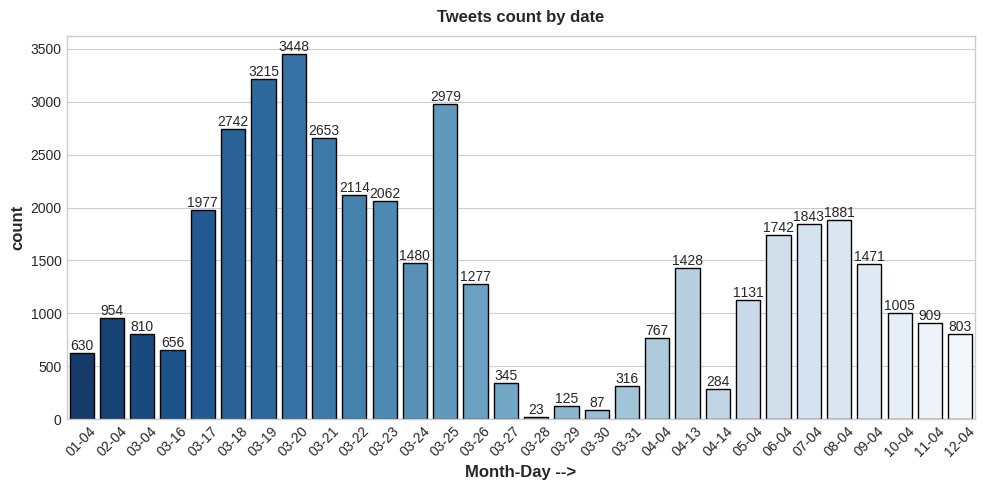

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="index", y="counts", hue="index", legend=False, data=tweets_per_day, edgecolor="black", errorbar=('ci', False), palette="Blues_r")
plt.title("Tweets count by date")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("count")
plt.xlabel("Month-Day -->")
plt.xticks(rotation=45)
plt.show()

We notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of March to the 26th of March.

In [ ]:
tweets_per_country = df["Location"].value_counts().loc[lambda x: x > 100].reset_index(name="counts")

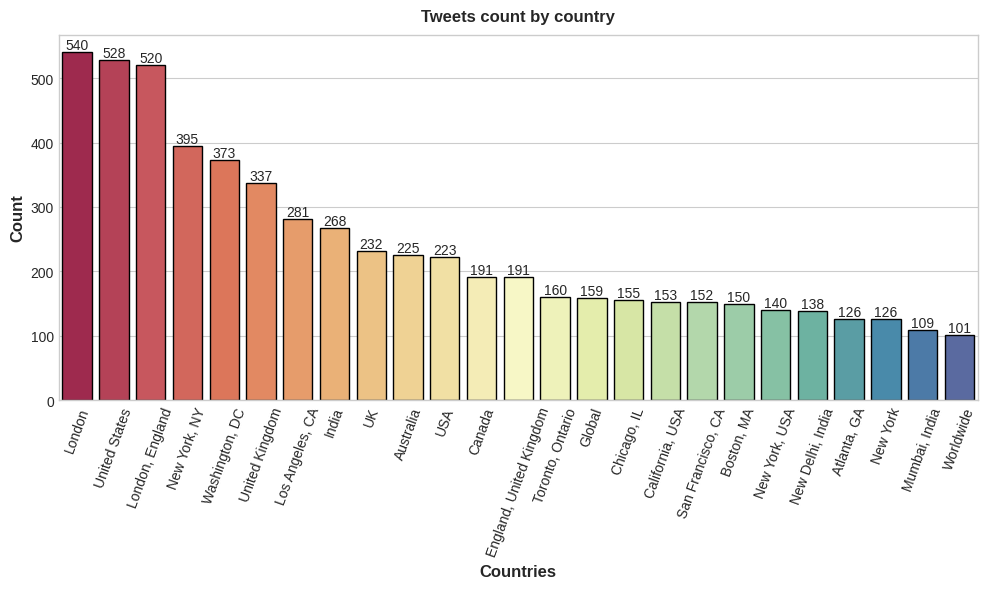

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="index", y="counts", hue="index", data=tweets_per_country, edgecolor="black", palette="Spectral")
plt.title("Tweets count by country")
plt.xticks(rotation=70)
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Count")
plt.xlabel("Countries")
plt.show()

The "Location" column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

## Tweets Deep Cleaning

Now, we will perform some data cleaning on the raw text of the tweets. To simplify the analysis, we will just keep the columns "Originaltweet" and the target column "Sentiment".

In [ ]:
df = df[["OriginalTweet", "Sentiment"]]

df_test = df_test[["OriginalTweet", "Sentiment"]]

### Helper function to lean the text of the tweets.

In [ ]:
# custom defined function to clean the text of the tweets

# clean emojis from text
def strip_emoji(text):
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

# remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
  text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
  text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
  text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
  banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
  table = str.maketrans('', '', banned_list)
  text = text.translate(table)
  return text

# clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
  new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
  new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
  return new_tweet2

# filter special characters such as & and $ present in some words
def filter_chars(a):
  sent = []
  for word in a.split(' '):
    if ("$" in word) | ("&" in word):
      sent.append("")
    else:
      sent.append(word)
  return " ".join(sent)

def remove_mult_spaces(text): # remove multiple spaces
  return re.sub("\s\s+", " ", text)

In [ ]:
texts_new = []
for t in df.OriginalTweet:
  texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
  texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we can create a new column, for both traina and test sets, to host the cleaned version of the tweet's text.

In [ ]:
df["text_clean"] = texts_new
df_test["text_clean"] = texts_new_test

In [ ]:
df["text_clean"].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [ ]:
df_test["text_clean"].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [ ]:
df["text_clean"][1: 8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

Moreover, we will also create a column to host the length of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [ ]:
text_len = []
for text in df.text_clean:
  tweet_len = len(text.split())
  text_len.append(tweet_len)

df["text_len"] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
  tweet_len = len(text.split())
  text_len_test.append(tweet_len)

df_test["text_len"] = text_len_test

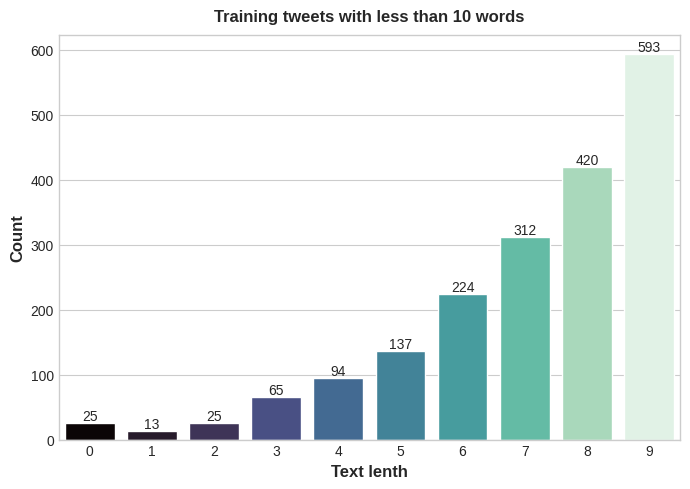

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x="text_len", data=df[df["text_len"]<10], hue="text_len", palette="mako", legend=False)
plt.title("Training tweets with less than 10 words")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Count")
plt.xlabel("Text lenth")
plt.show()

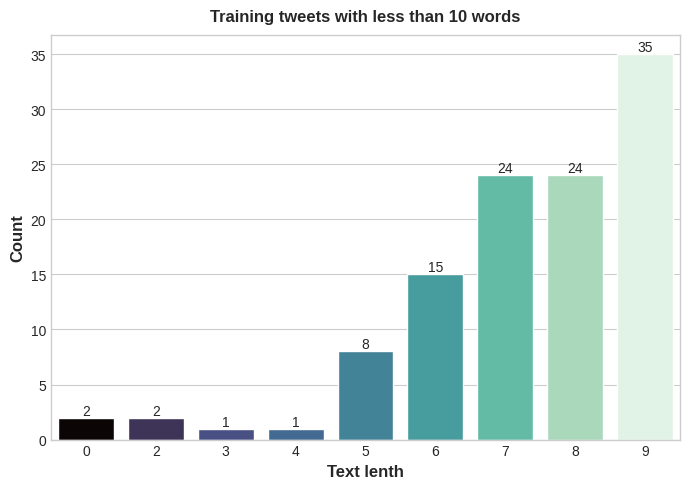

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x="text_len", data=df_test[df_test["text_len"]<10], hue="text_len", palette="mako", legend=False)
plt.title("Training tweets with less than 10 words")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Count")
plt.xlabel("Text lenth")
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [ ]:
print(f"Df Shape: {df.shape}")
print(f"Df_test Shape: {df_test.shape}")

print("-----------------------------")
df = df[df["text_len"] > 4]
df_test = df_test[df_test["text_len"] > 4]

print(f"Df Shape: {df.shape}")
print(f"Df_test Shape: {df_test.shape}")

Df Shape: (41157, 4)
Df_test Shape: (3798, 4)
-----------------------------
Df Shape: (40935, 4)
Df_test Shape: (3792, 4)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import BERT tokenizer

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df["text_clean"].values:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

max_len = np.max(token_lens)

print(f"Max tokenized sentence lenth: {max_len}")

Max tokenized sentence lenth: 100


Let's check the long tokenized sentences (with more than 80 tokens)

In [ ]:
token_lens = []

for i, txt in enumerate(df["text_clean"].values):
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))
  if len(tokens) > 80:
    print(f"Index: {i}, Text: {txt}")

Index: 1622, Text: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
Index: 13623, Text: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
Index: 16548, Text: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
Index: 36953, Text: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

These sentences are not in english. They should be dropped.

In [ ]:
df["token_lens"] = token_lens

In [ ]:
df = df.sort_values(by="token_lens", ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


The dataset looks more clean now. We will shuflle it and reset the index.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [ ]:
token_lens_test = []

for txt in df_test["text_clean"].values:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_test.append(len(tokens))

max_len = np.max(token_lens_test)

print(f"Max tokenized sentence length: {max_len}")

token_lens_test = []

for i, txt in enumerate(df_test["text_clean"].values):
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_test.append(len(tokens))
  if len(tokens) > 80:
    print(f"Index: {i}, Text: {txt}")

Max tokenized sentence length: 96
Index: 286, Text: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
Index: 345, Text: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
Index: 2380, Text: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [ ]:
df_test["token_lens"] = token_lens_test

df_test = df_test.sort_values(by="token_lens", ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if i have new ideas.

## Sentiment column analysis

Now we will look at the target column `Sentiment`.

In [ ]:
df["Sentiment"].value_counts()

Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: Sentiment, dtype: int64

The first thing we can do is encode the categories with numbers. We will also create 3 possible emotions: Positive, Neutra and Negative

In [ ]:
df["Sentiment"] = df["Sentiment"].map({"Extremely Negative": 0,
                                       "Negative": 0,
                                       "Neutral": 1,
                                       "Positive": 2,
                                       "Extremely Positive": 2})

df_test["Sentiment"] = df_test["Sentiment"].map({"Extremely Negative": 0,
                                       "Negative": 0,
                                       "Neutral": 1,
                                       "Positive": 2,
                                       "Extremely Positive": 2})

In [ ]:
df["Sentiment"].value_counts()

2    17999
0    15364
1     7560
Name: Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the training samples, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df["text_clean"]).reshape(-1, 1), np.array(df["Sentiment"]).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns=["text_clean", "Sentiment"])

In [ ]:
train_os["Sentiment"].value_counts()

2    17999
0    17999
1    17999
Name: Sentiment, dtype: int64

## Saving processed train and test datasets

In [ ]:
train_os.to_csv("train_data_processed.csv", index=False)

df_test[["text_clean", "Sentiment"]].to_csv("test_data_processed.csv", index=False)

### Create train, valid datasets

In [ ]:
X = train_os["text_clean"].values
y = train_os["Sentiment"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test["text_clean"].values
y_test = df_test["Sentiment"].values

## One Hot encoding of labels

First we will save a copy of the labels encoded target colum since they could be useful later

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"Training data: {X_train.shape[0]}")
print(f"Valid data: {X_valid.shape[0]}")
print(f"Test data: {X_test.shape[0]}")

Training data: 48597
Valid data: 5400
Test data: 3787


## Baseline Model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayse baseline model to classify the tweets.
1. We will tokenize the tweets using `CountVectorizer`
2. We create the `Tf-Idf` version
3. Train the `multinomialnb` model
4. Evaluate the model

In [ ]:
# count vectorize
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# tfidf
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# fit nb model
nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train_le)

# make predictions
nb_pred = nb_clf.predict(X_test_tf)

# Print evaluation report
print("\tClassification Report for Naive Bayes: \n")
print(classification_report(y_test_le, nb_pred, target_names=["Negative", "Neutral", "Positive"]))

	Classification Report for Naive Bayes: 

              precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.74      0.72      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



The algorithm performace is not so bad.
The f1 score is around 70% for the more populated classes (Negative and Positive emotions) and lower for the Neutral class (f1=0.50)

In particular, the overall accuracy is 70%